### **Exploratory Data Analysis**

In [1]:
# IMPORTS

import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import kendalltau, chi2_contingency
import seaborn as sns

In [2]:
# LOAD DATASET

df = pd.read_csv("drug_consumption.csv")
# Remove records claiming use of "Semeron" (fake drug to identify drug seekers)
df = df[df['semer'] == 'CL0']
feature_file_dict = {f"{feat}":f"additional-variable-information/{i}-{feat}.csv" for i,feat in enumerate(df.columns.to_list())}
# Categorize all feature variables by data types
all_vars = df.columns.tolist()
nominal_vars = ['gender', 'country', 'ethnicity']
ordinal_vars = ['age', 'education', 'alcohol', 'amphet', 'amyl', 'benzos', 'caff', 'cannabis', 
    'choc', 'coke', 'crack', 'ecstasy', 'heroin', 'ketamine', 'legalh', 'lsd', 'meth', 
    'mushrooms', 'nicotine', 'vsa']
demographic_vars = ['age', 'gender', 'education', 'country', 'ethnicity']
ffi_vars = ['n_score', 'e_score', 'o_score', 'a_score', 'c_score']
personality_vars = ['n_score', 'e_score', 'o_score', 'a_score', 'c_score',
    'impulsive_bis11', 'sensation_seeking_impss']
drug_vars = ['alcohol', 'amphet', 'amyl', 'benzos', 'caff', 'cannabis', 
    'choc', 'coke', 'crack', 'ecstasy', 'heroin', 'ketamine', 'legalh', 
    'lsd', 'meth', 'mushrooms', 'nicotine', 'vsa']

#### **Initial Visualizations**

In [3]:
# CONVERT INPUT FEATURE VALUES TO MEANINGS (FOR READABILITY)

# Convert input_df feature values with each variable value's corresponding meaning
for var_dem in demographic_vars:
    df_var = pd.read_csv(feature_file_dict[var_dem], usecols=['Value', 'Meaning'])
    value_meanings = pd.Series(df_var['Meaning'].values, index=df_var['Value']).to_dict()
    df[var_dem] = df[var_dem].map(value_meanings)
for score in ffi_vars:
    score_col = f"{score[0].capitalize()}score"
    df_score = pd.read_csv(feature_file_dict[score], usecols=[score_col, 'Value'])
    value_scores = pd.Series(df_score[score_col].values, index=df_score['Value']).to_dict()
    df[score] = df[score].map(value_scores)

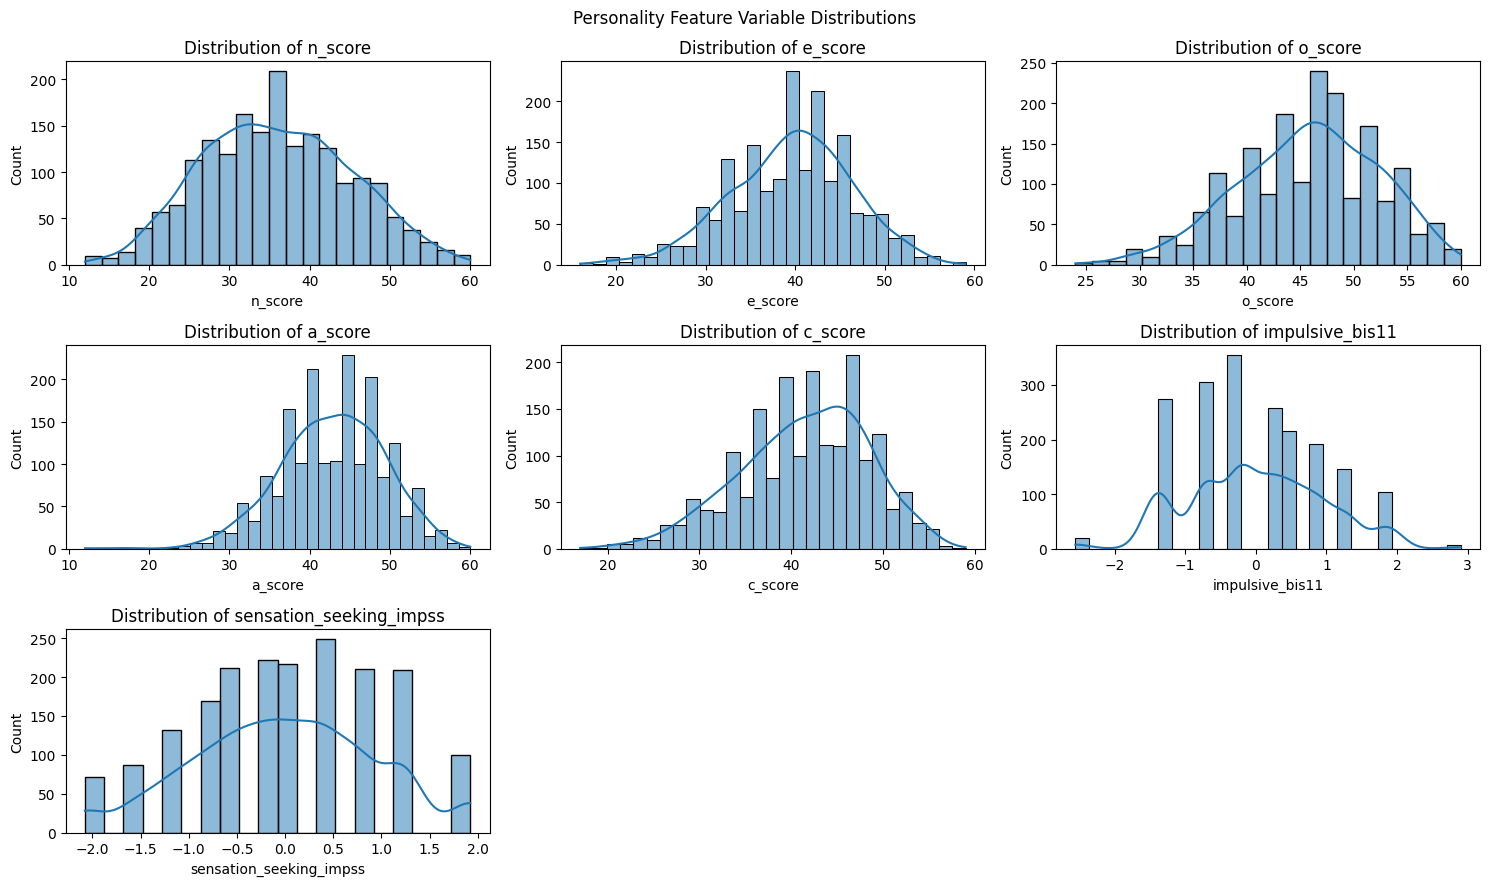

In [4]:
# NUMERIC FEATURES

# Set grid dimensions of visualizations
n_cols = 3
n_numeric = len(personality_vars)
n_rows = math.ceil(n_numeric / n_cols)
# Create figure containing distribution visualizations!
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 3*n_rows))
for i, col in enumerate(personality_vars):
    row, col_idx = divmod(i, n_cols)
    ax = axes[row, col_idx] if n_rows > 1 else axes[col_idx]
    sns.histplot(df[col], kde=True, ax=ax)
    ax.set_title(f'Distribution of {col}')
# Hide empty plots
for j in range(i+1, n_rows * n_cols):
    row, col_idx = divmod(j, n_cols)
    ax = axes[row, col_idx] if n_rows > 1 else axes[col_idx]
    ax.axis('off')
    
plt.suptitle("Personality Feature Variable Distributions")
plt.tight_layout()
plt.show()

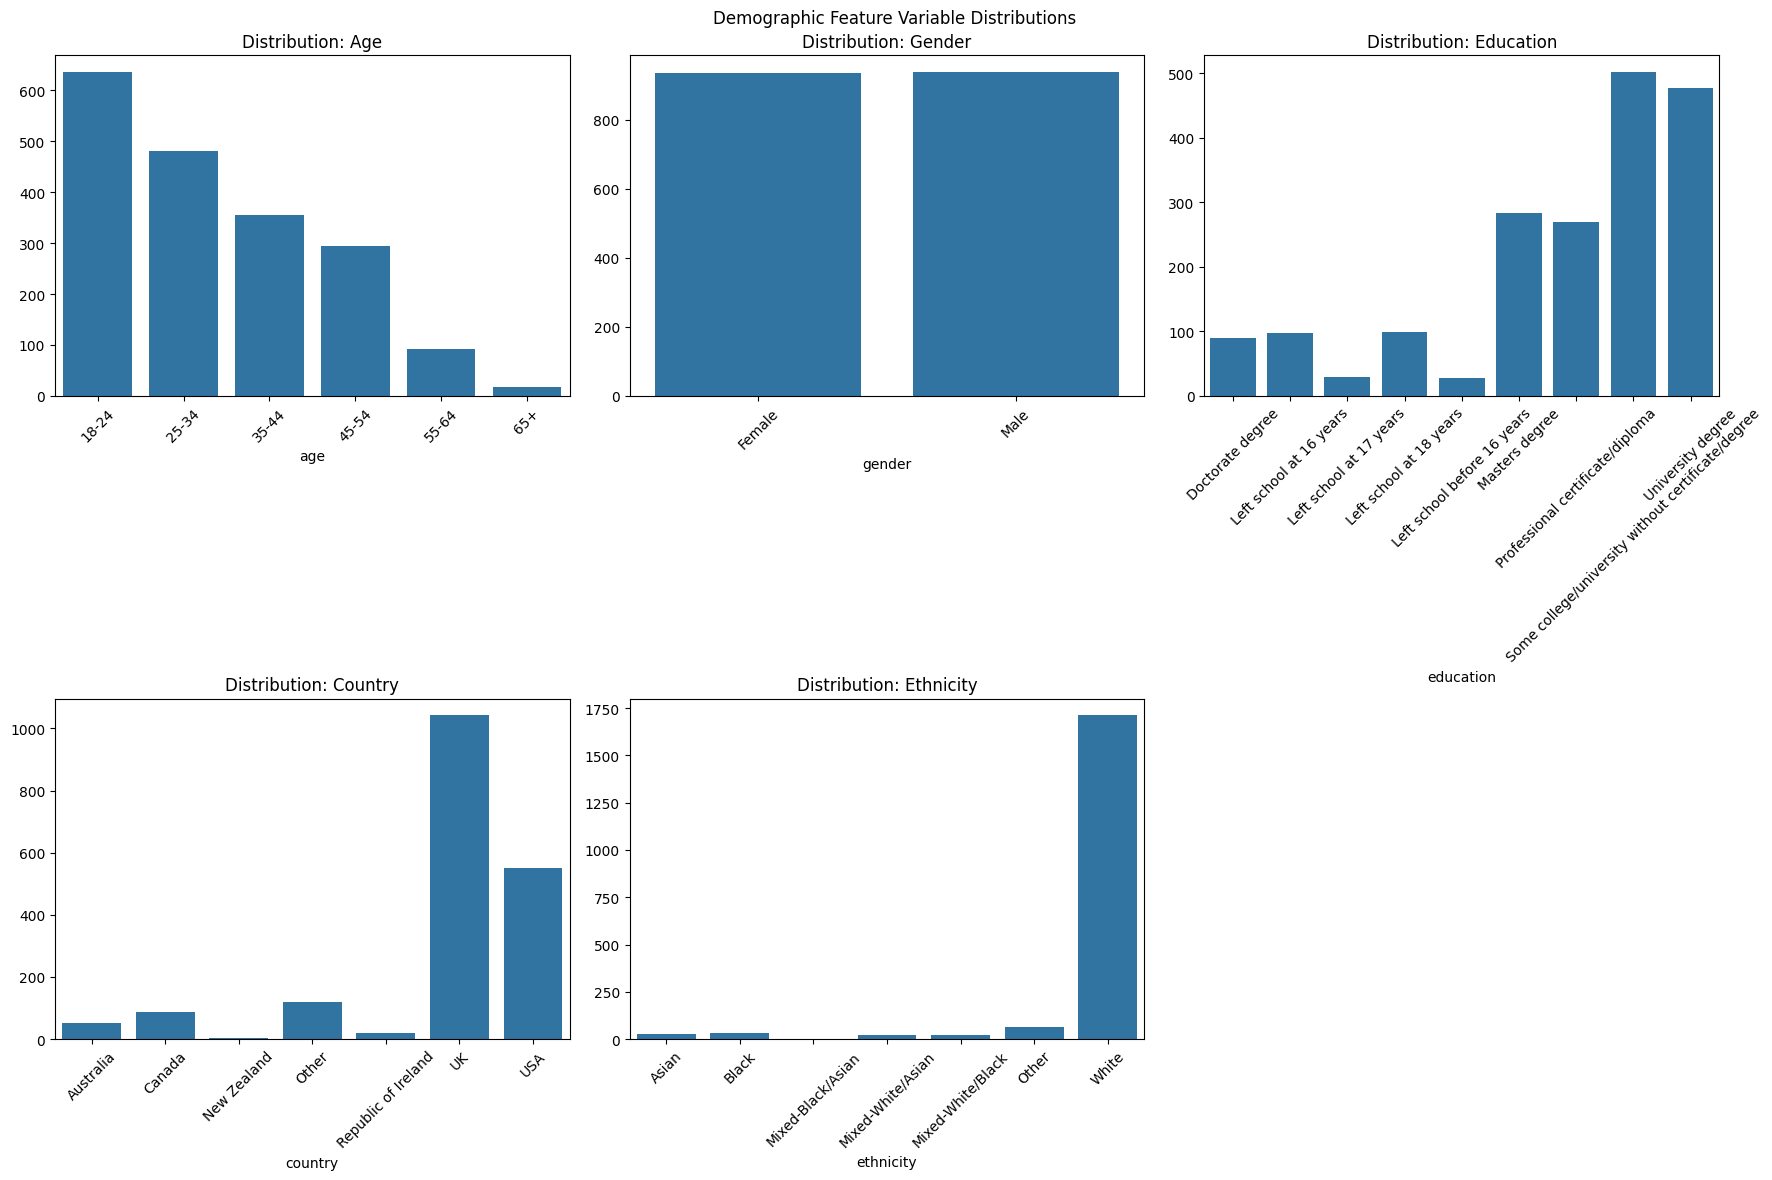

In [5]:
# CATEGORICAL

# Set grid dimensions of visualizations
n_cols = 3
n_demo = len(demographic_vars)
n_rows = math.ceil(n_demo / n_cols)
# Create figure containing distribution visualizations!
fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 6*n_rows))
for i, var in enumerate(demographic_vars):
    row, col_idx = divmod(i, n_cols)
    ax = axes[row, col_idx] if n_rows > 1 else axes[col_idx]
    sns.countplot(x=var, data=df, ax=ax, order=sorted(df[var].unique()))
    ax.set_title(f'Distribution: {var.title()}')
    ax.tick_params(axis='x', rotation=45)
    ax.set_ylabel('')
# Hide any empty subplots
for j in range(i+1, n_rows * n_cols):
    row, col_idx = divmod(j, n_cols)
    ax = axes[row, col_idx] if n_rows > 1 else axes[col_idx]
    ax.axis('off')

plt.suptitle("Demographic Feature Variable Distributions")
plt.tight_layout()
plt.show()

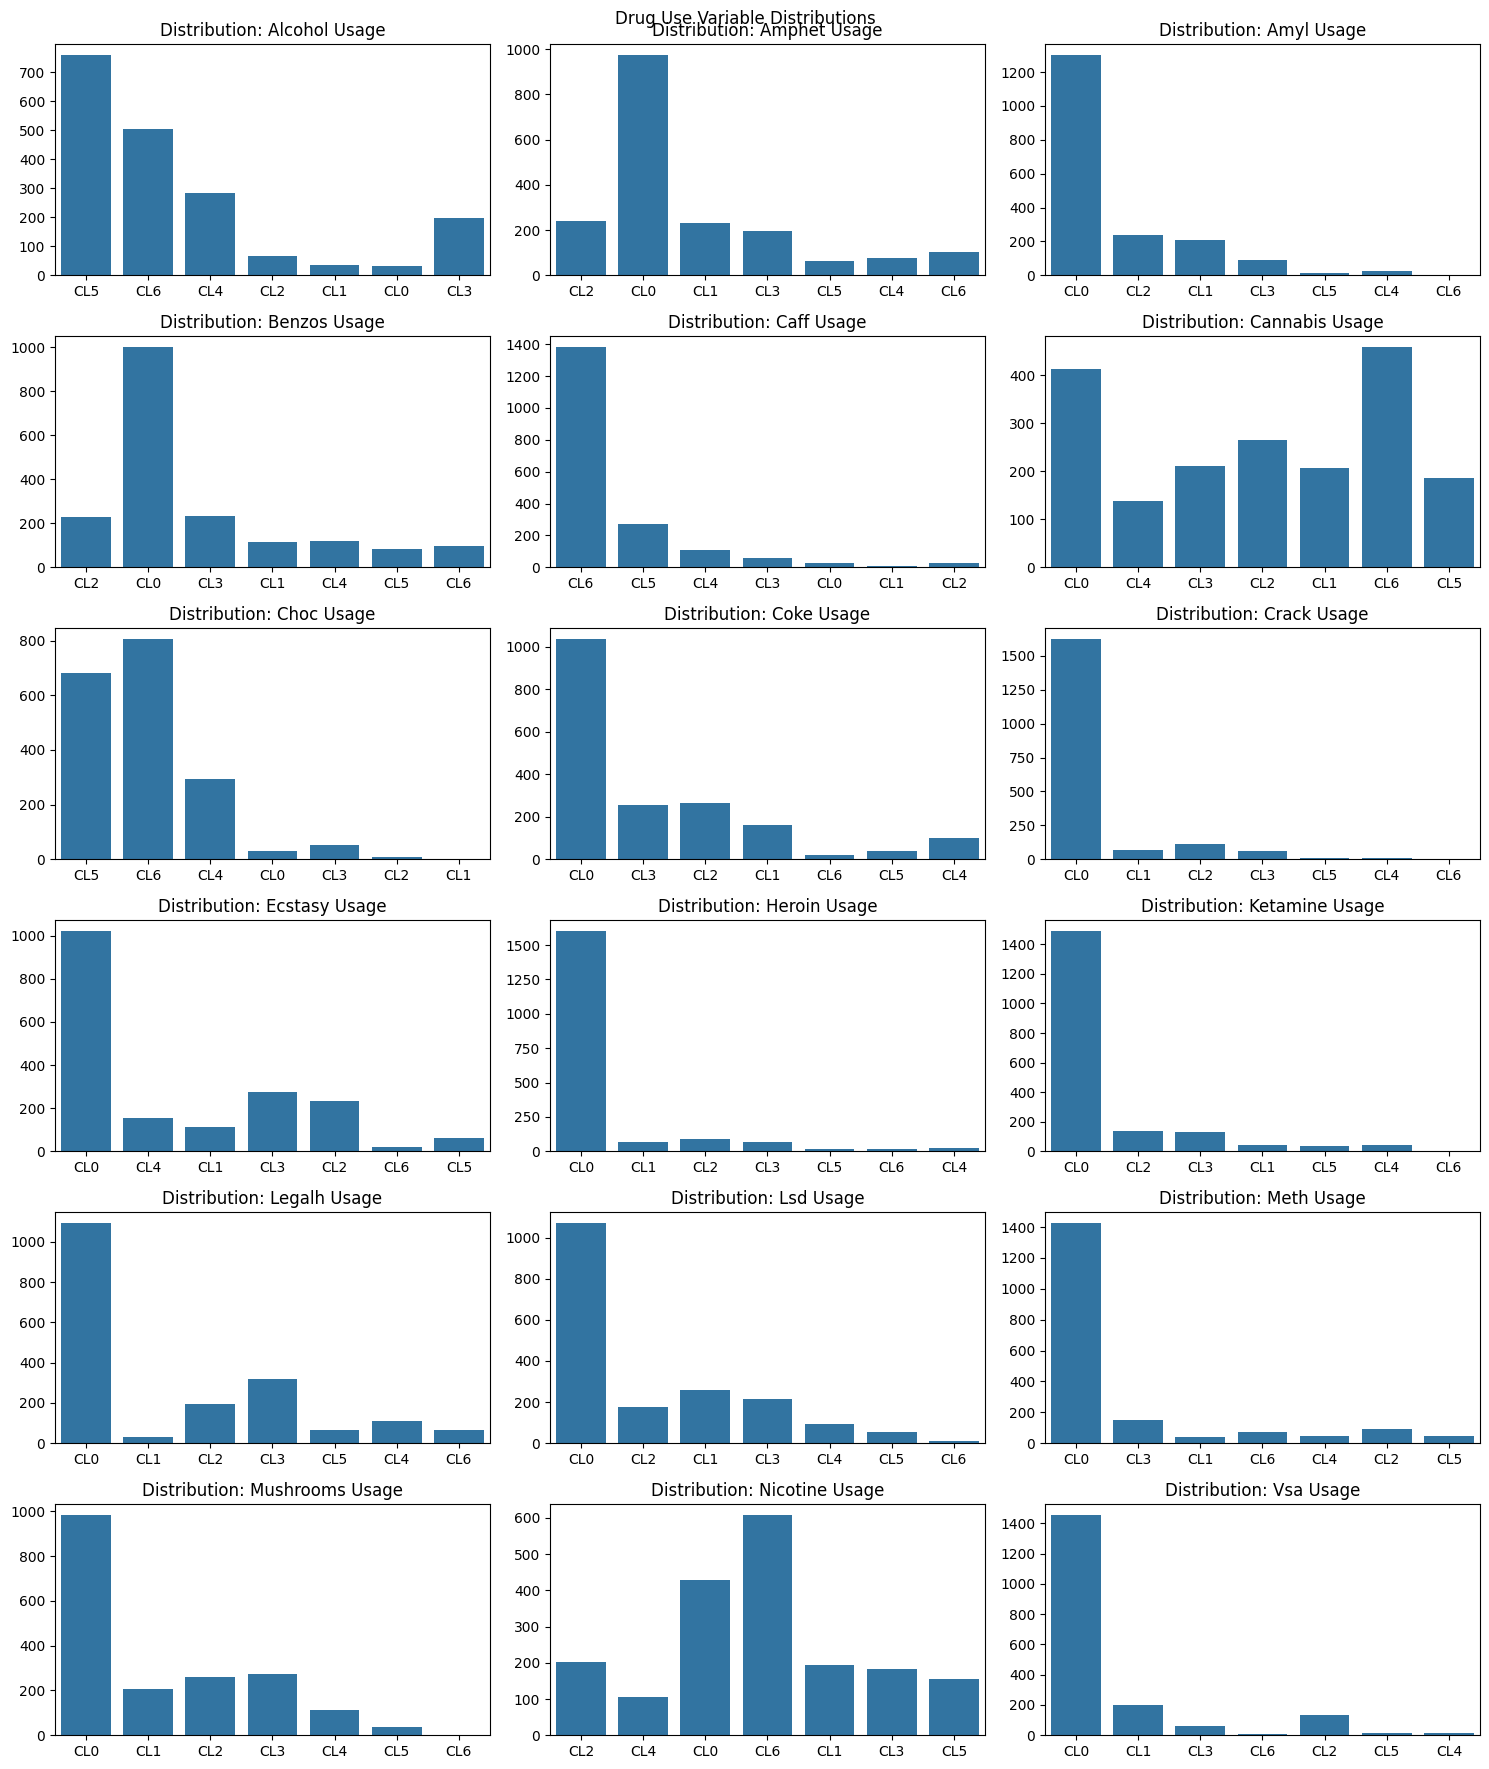

In [6]:
# TARGET FEATURES (DRUG USE)

# Set grid dimensions of visualizations
n_cols = 3
n_drugs = len(drug_vars)
n_rows = math.ceil(n_drugs / n_cols)
# Create figure containing distribution visualizations!
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 3*n_rows))
for i, var in enumerate(drug_vars):
    row, col_idx = divmod(i, n_cols)
    ax = axes[row, col_idx] if n_rows > 1 else axes[col_idx]
    sns.countplot(x=var, data=df, ax=ax)
    ax.set_title(f'Distribution: {var.title()} Usage')
    ax.set_xlabel('')
    ax.set_ylabel('')
# Hide any empty subplots
for j in range(i+1, n_rows * n_cols):
    row, col_idx = divmod(j, n_cols)
    ax = axes[row, col_idx] if n_rows > 1 else axes[col_idx]
    ax.axis('off')

plt.suptitle("Drug Use Variable Distributions")
plt.tight_layout()
plt.show()

#### **Pairwise Correlation Matrix**

In [7]:
# CONVERT DRUG VALUES

# Handle CL[1-9] values used to indicate recency of drug use with a NON-LINEAR (exponential) scale to emphasize recency
drug_class_map = {f'CL{i}': 2**i for i in range(7)}
for drug in drug_vars:
    df[drug] = df[drug].map(drug_class_map) 

In [8]:
# DEFINE CORRELATION FUNCTIONS

# Cramer's V (Nominal-nominal pair)
# https://stackoverflow.com/questions/46498455/categorical-features-correlation/46498792#46498792
def cramers_v_stat(confusion_matrix):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher,
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.values.sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    rcorr = r - ((r - 1) ** 2) / (n - 1)
    kcorr = k - ((k - 1) ** 2) / (n - 1)
    return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))

def cramers_v(a, b):
    confusion_matrix = pd.crosstab(a, b)
    return cramers_v_stat(confusion_matrix)

def correlation_ratio(categories, measurements):
    categories = pd.Categorical(categories)
    cat_num = len(categories.categories)
    y_avg_array = np.zeros(cat_num)
    n_array = np.zeros(cat_num)
    for i, cat in enumerate(categories.categories):
        cat_measures = measurements[categories == cat]
        n_array[i] = len(cat_measures)
        y_avg_array[i] = np.mean(cat_measures) if len(cat_measures) > 0 else 0
    y_total_avg = np.sum(y_avg_array * n_array) / np.sum(n_array)
    numerator = np.sum(n_array * (y_avg_array - y_total_avg) ** 2)
    denominator = np.sum((measurements - y_total_avg) ** 2)
    if denominator == 0:
        return 0.0
    else:
        return np.sqrt(numerator / denominator)

Strongest correlation (+/-): 
Variable 1: Lsd
Variable 2: Mushrooms 
Value: 0.623


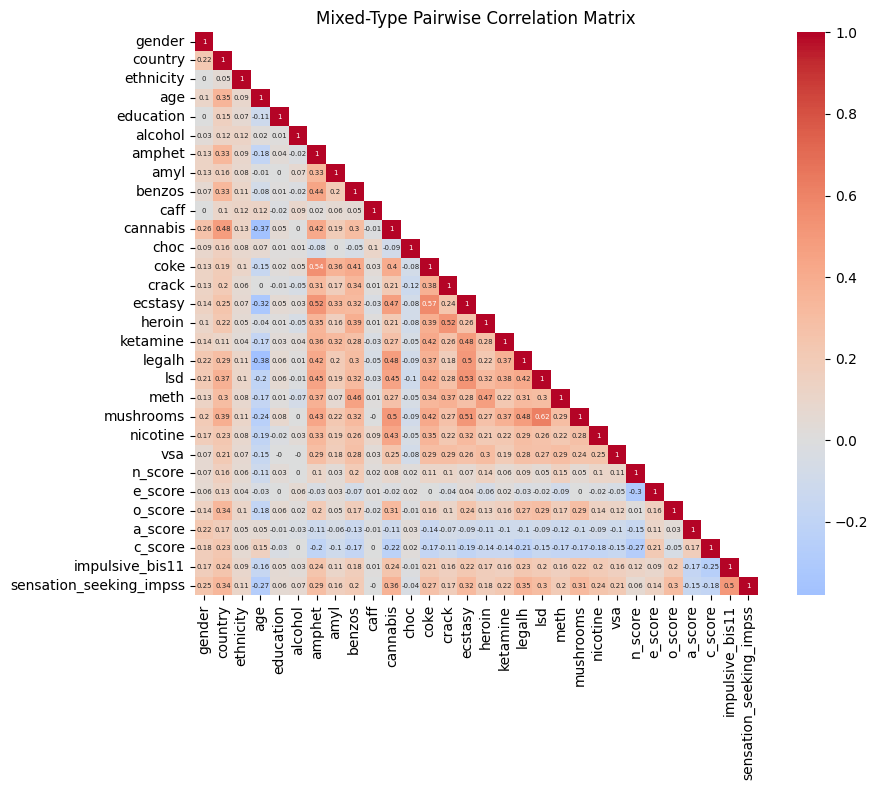

In [9]:
# BUILD MATRIX

def to_numeric_series(series):
    """Convert a categorical series to numeric codes if not already numeric."""
    if pd.api.types.is_numeric_dtype(series):
        return series
    return pd.Series(pd.Categorical(series).codes, index=series.index)

matrix_vars = nominal_vars + ordinal_vars + personality_vars
corr_matrix = pd.DataFrame(np.nan, index=matrix_vars, columns=matrix_vars)
strong_c = 0
var_s1 = var_s2 = ""
# Fill matrix with values
for i, var1 in enumerate(matrix_vars):
    for j, var2 in enumerate(matrix_vars):
        if i > j:
            continue  # Fill upper triangle only
        if var1 == var2:
            corr_matrix.loc[var1, var2] = 1.0
        elif var1 in personality_vars and var2 in personality_vars: # Use Kendall's tau for numeric-numeric
            tau, _ = kendalltau(df[var1], df[var2])
            corr_matrix.loc[var2, var1] = tau
            if np.abs(tau) > strong_c:
                strong_c = tau
                var_s1, var_s2 = var1, var2
        elif (var1 in personality_vars and var2 in ordinal_vars) or (var2 in personality_vars and var1 in ordinal_vars):    # Use Kendall's tau for numeric-ordinal
            tau, _ = kendalltau(df[var1], df[var2])
            corr_matrix.loc[var2, var1] = tau
            if np.abs(tau) > strong_c:
                strong_c = tau
                var_s1, var_s2 = var1, var2
        elif var1 in ordinal_vars and var2 in ordinal_vars: # Use Kendall's tau for ordinal-ordinal
            tau, _ = kendalltau(df[var1], df[var2])
            corr_matrix.loc[var2, var1] = tau
            if np.abs(tau) > strong_c:
                strong_c = tau
                var_s1, var_s2 = var1, var2
        elif var1 in nominal_vars and var2 in nominal_vars: # Use Cramér's V for nominal-nominal
            v = cramers_v(df[var1], df[var2])
            corr_matrix.loc[var2, var1] = v
            if np.abs(v) > strong_c:
                strong_c = v
                var_s1, var_s2 = var1, var2
        else:   # Mixed: nominal with numeric or ordinal (use correlation ratio)
            if var1 in nominal_vars:
                eta = correlation_ratio(to_numeric_series(df[var1]), to_numeric_series(df[var2]))
            else:
                eta = correlation_ratio(to_numeric_series(df[var2]), to_numeric_series(df[var1]))
            corr_matrix.loc[var2, var1] = eta
            if np.abs(eta) > strong_c:
                strong_c = eta
                var_s1, var_s2 = var1, var2 # Visualize complete pairwise correlation matrix
corr_matrix = corr_matrix.round(2)
print(f"Strongest correlation (+/-): \nVariable 1: {var_s1.title()}\nVariable 2: {var_s2.title()} \nValue: {strong_c:.3f}")
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, annot_kws={"fontsize": 5}, cmap="coolwarm", center=0, square=True)
plt.title("Mixed-Type Pairwise Correlation Matrix")
plt.tight_layout()
plt.show()

In [10]:
# Correlation Matrix Interpretation
# 1. There're no feature pairs with near-perfect correlation 
#    (abs[corr] >= 0.8), so we shouldn't drop features 
#    to avoid redundancy. Moreover, no features have an 
#    extremely strong relationship with many others, so we 
#    can/should keep most/all features.
# 2. Linear models will not generate great results with these
#    features, so we should progress as advised in lecture to
#    use tree-based or other non-linear models.

#### **PCA Visualizations**

Generating Visualization 1: PCA Group Distributions...


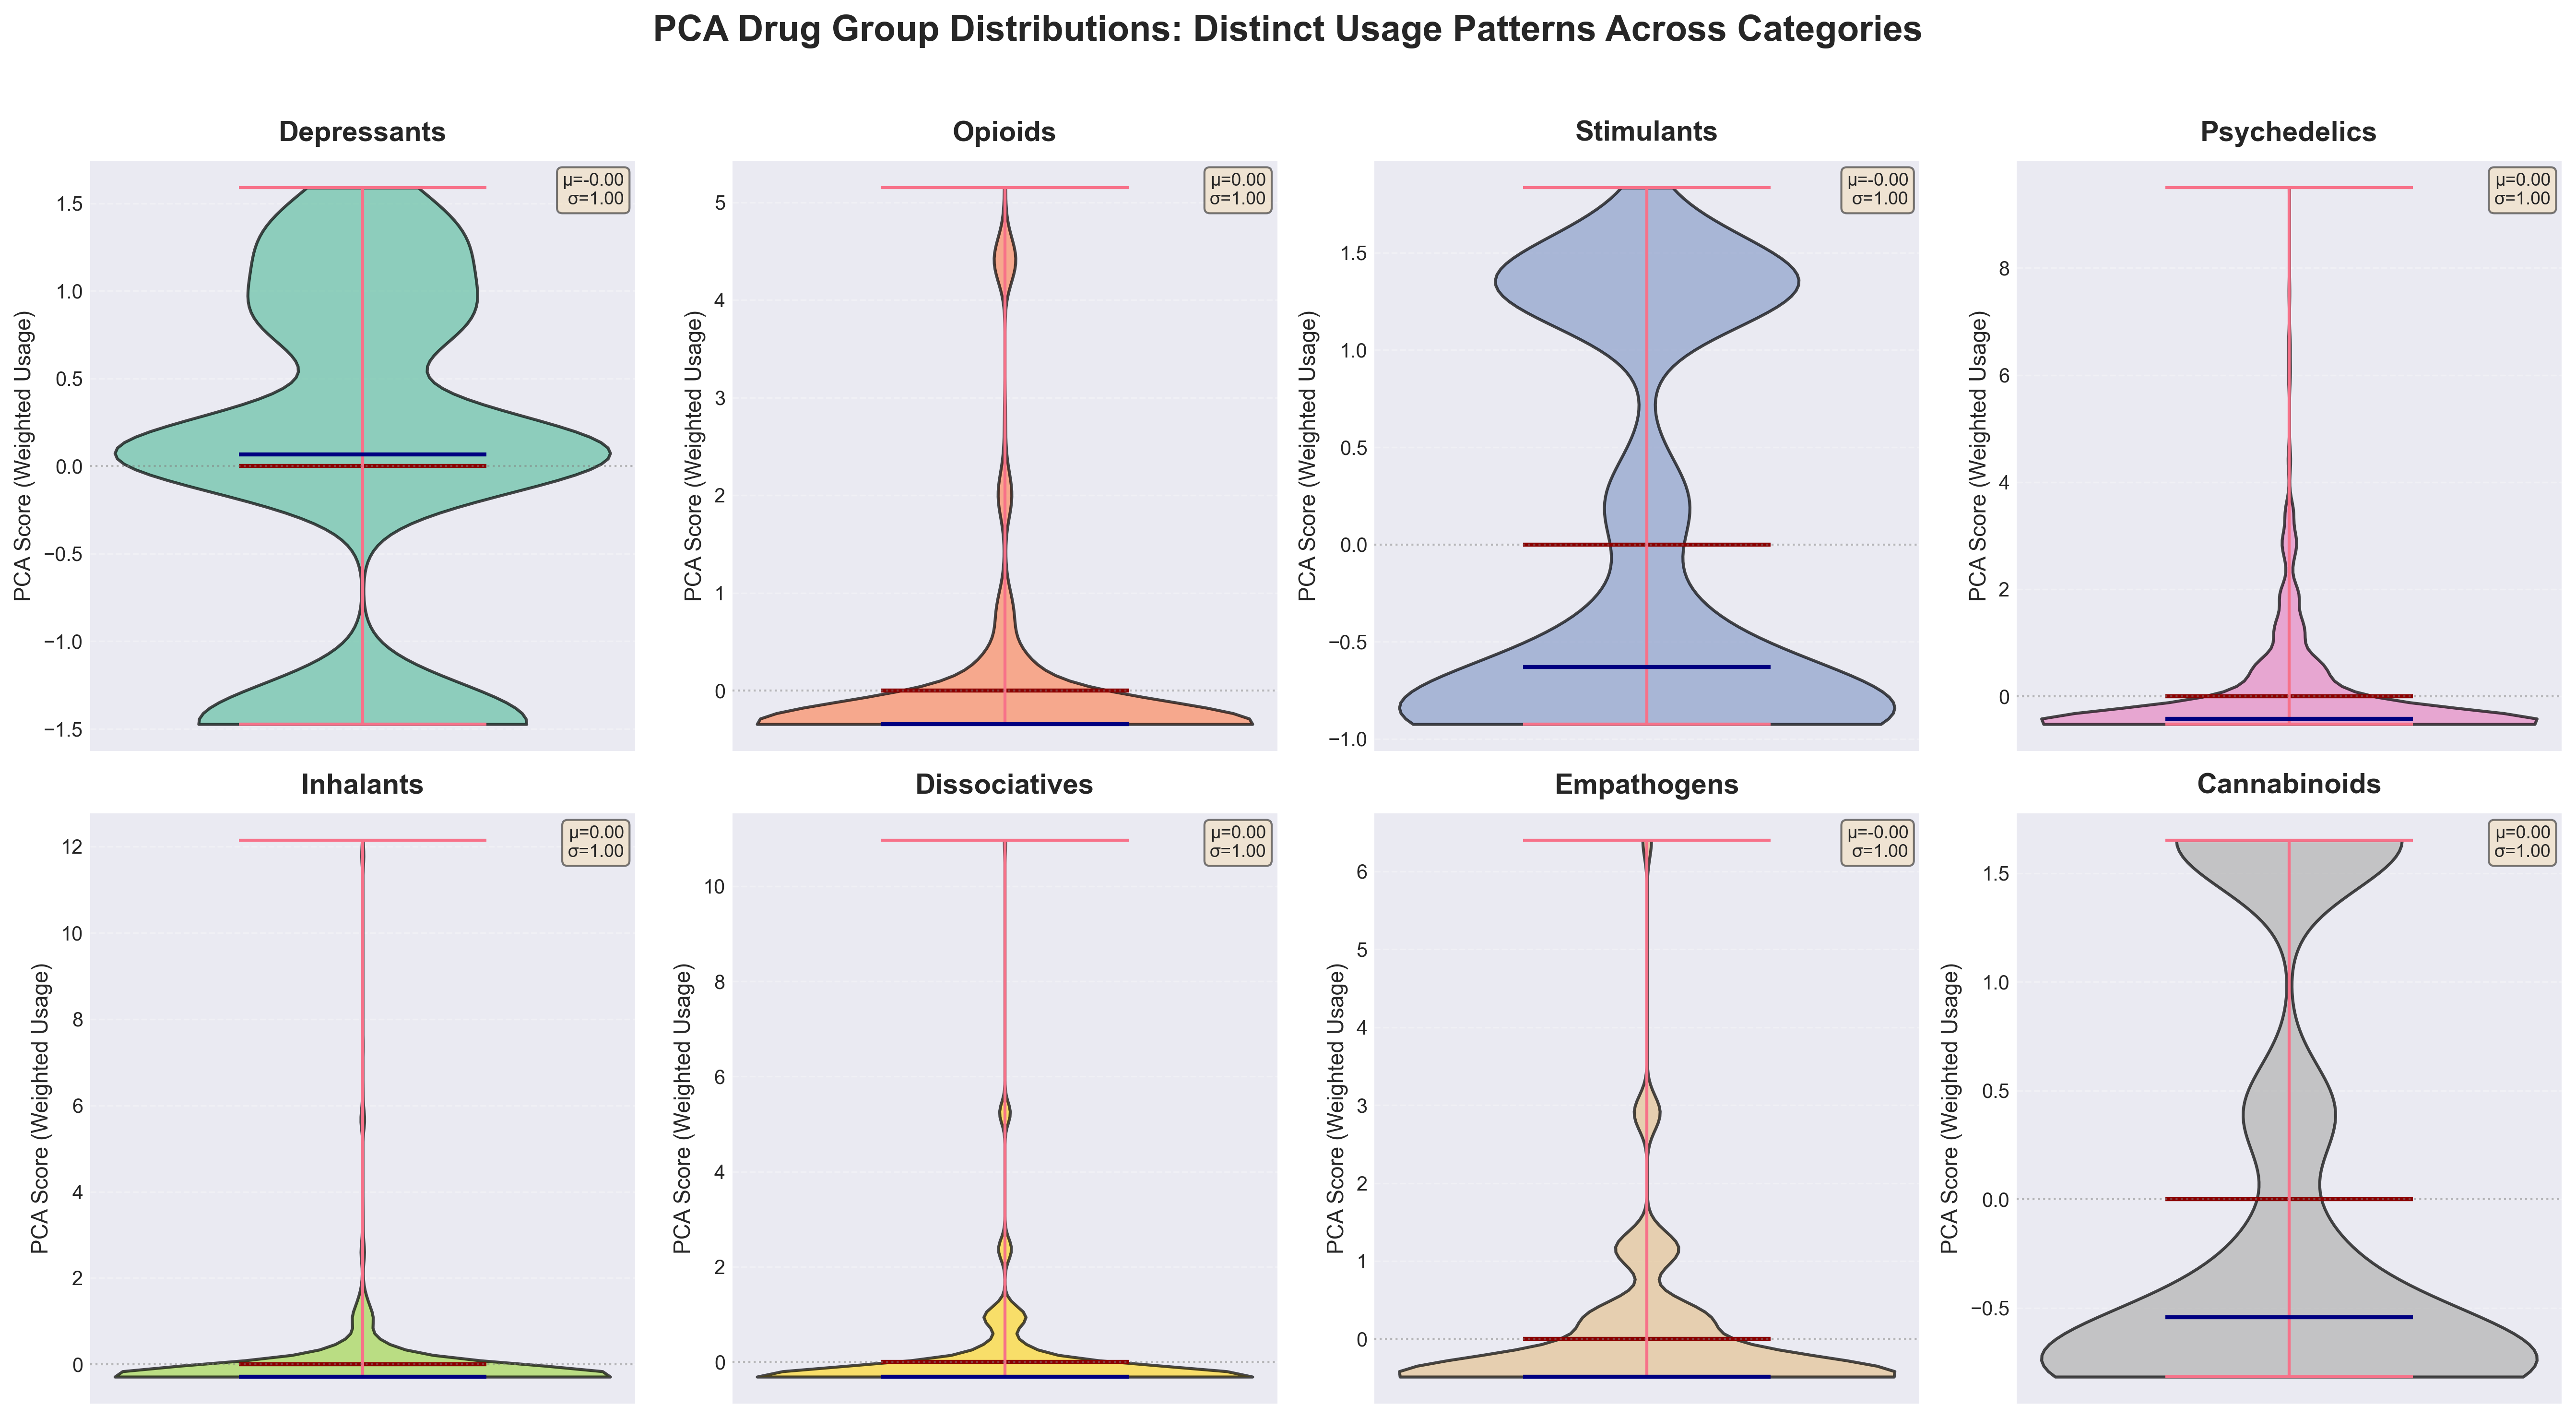

✓ Saved: PCA_Visuals/pca_distributions.png

Generating Visualization 2: Personality-Drug Correlations...


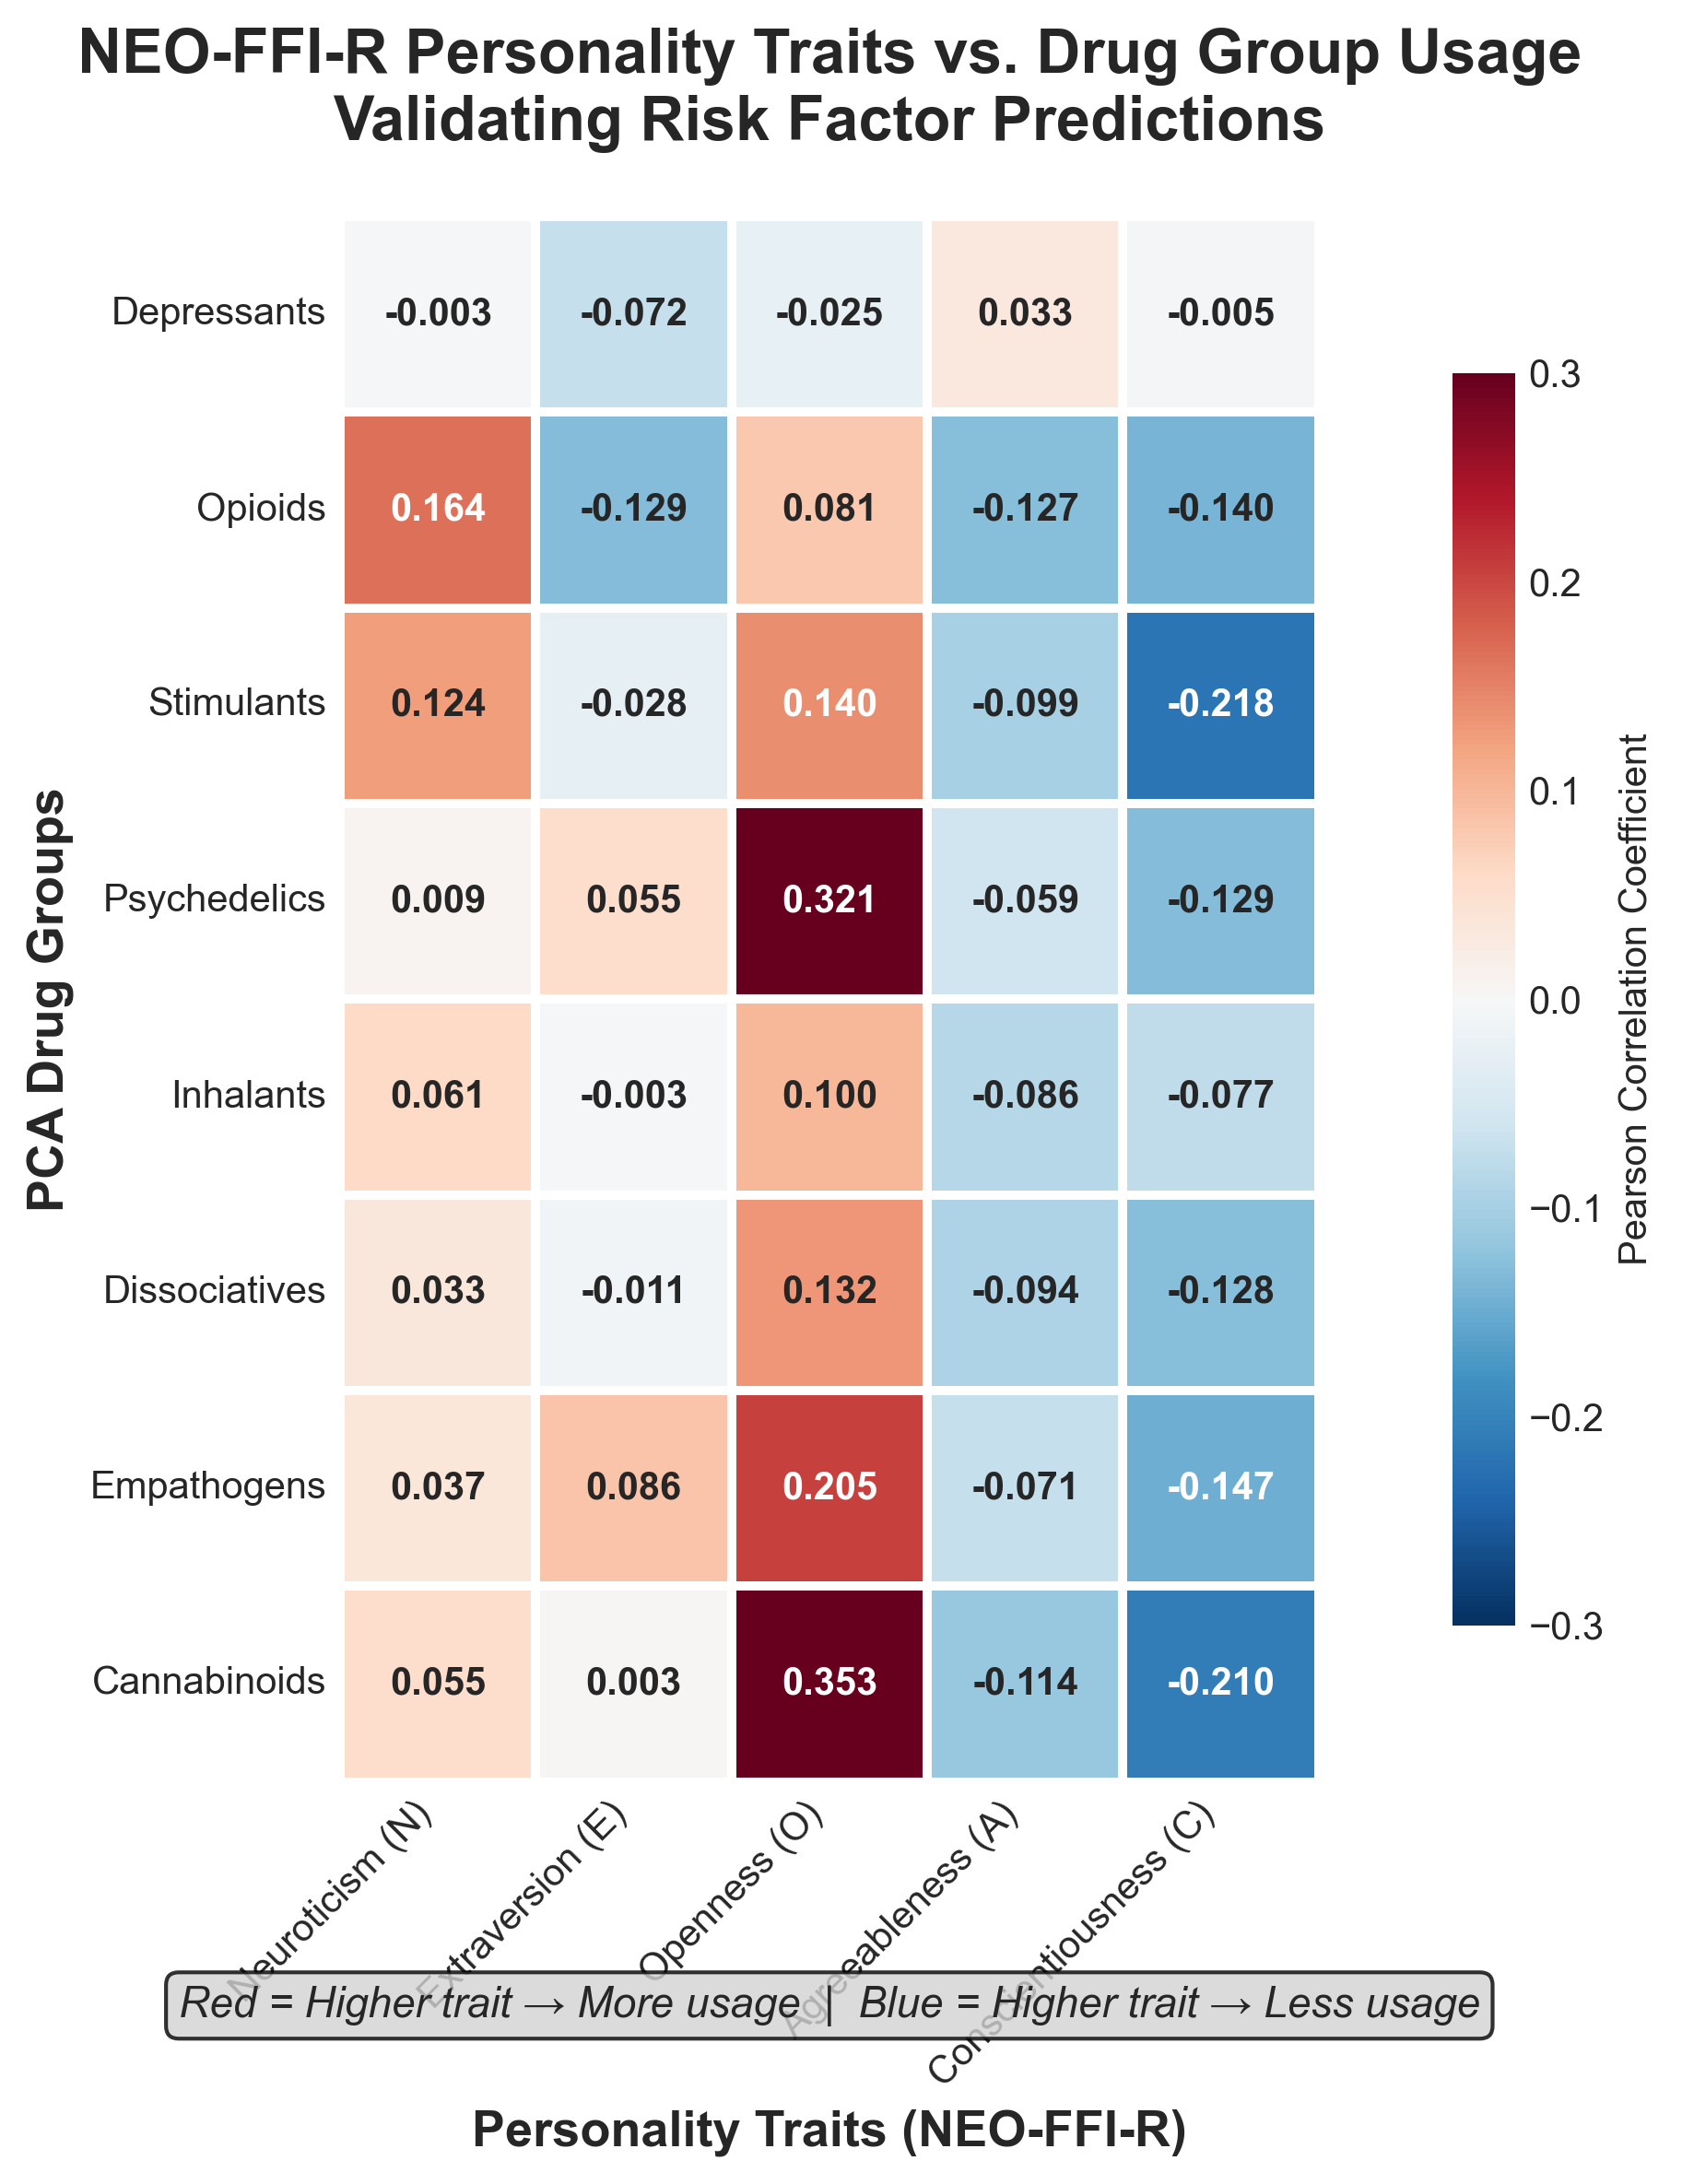

✓ Saved: PCA_Visuals/personality_drug_correlation.png

📊 KEY FINDINGS FOR SLIDES:
  • Neuroticism (N) increases Opioids risk (r=0.164)
  • Conscientiousness (C) decreases Stimulants risk (r=-0.218)
  • Openness (O) increases Psychedelics risk (r=0.321)
  • Openness (O) increases Empathogens risk (r=0.205)
  • Openness (O) increases Cannabinoids risk (r=0.353)
  • Conscientiousness (C) decreases Cannabinoids risk (r=-0.210)

Generating Visualization 3: Education-Based Risk Profiles...


/var/folders/64/wpz7s05x7bl1hv234gmx3bcr0000gn/T/ipykernel_9035/4028389446.py:246: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/var/folders/64/wpz7s05x7bl1hv234gmx3bcr0000gn/T/ipykernel_9035/4028389446.py:246: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/var/folders/64/wpz7s05x7bl1hv234gmx3bcr0000gn/T/ipykernel_9035/4028389446.py:246: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/var/folders/64/wpz7s05x7bl1hv234gmx3bcr0000gn/T/ipykernel_9035/4028389446.py:246: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated a

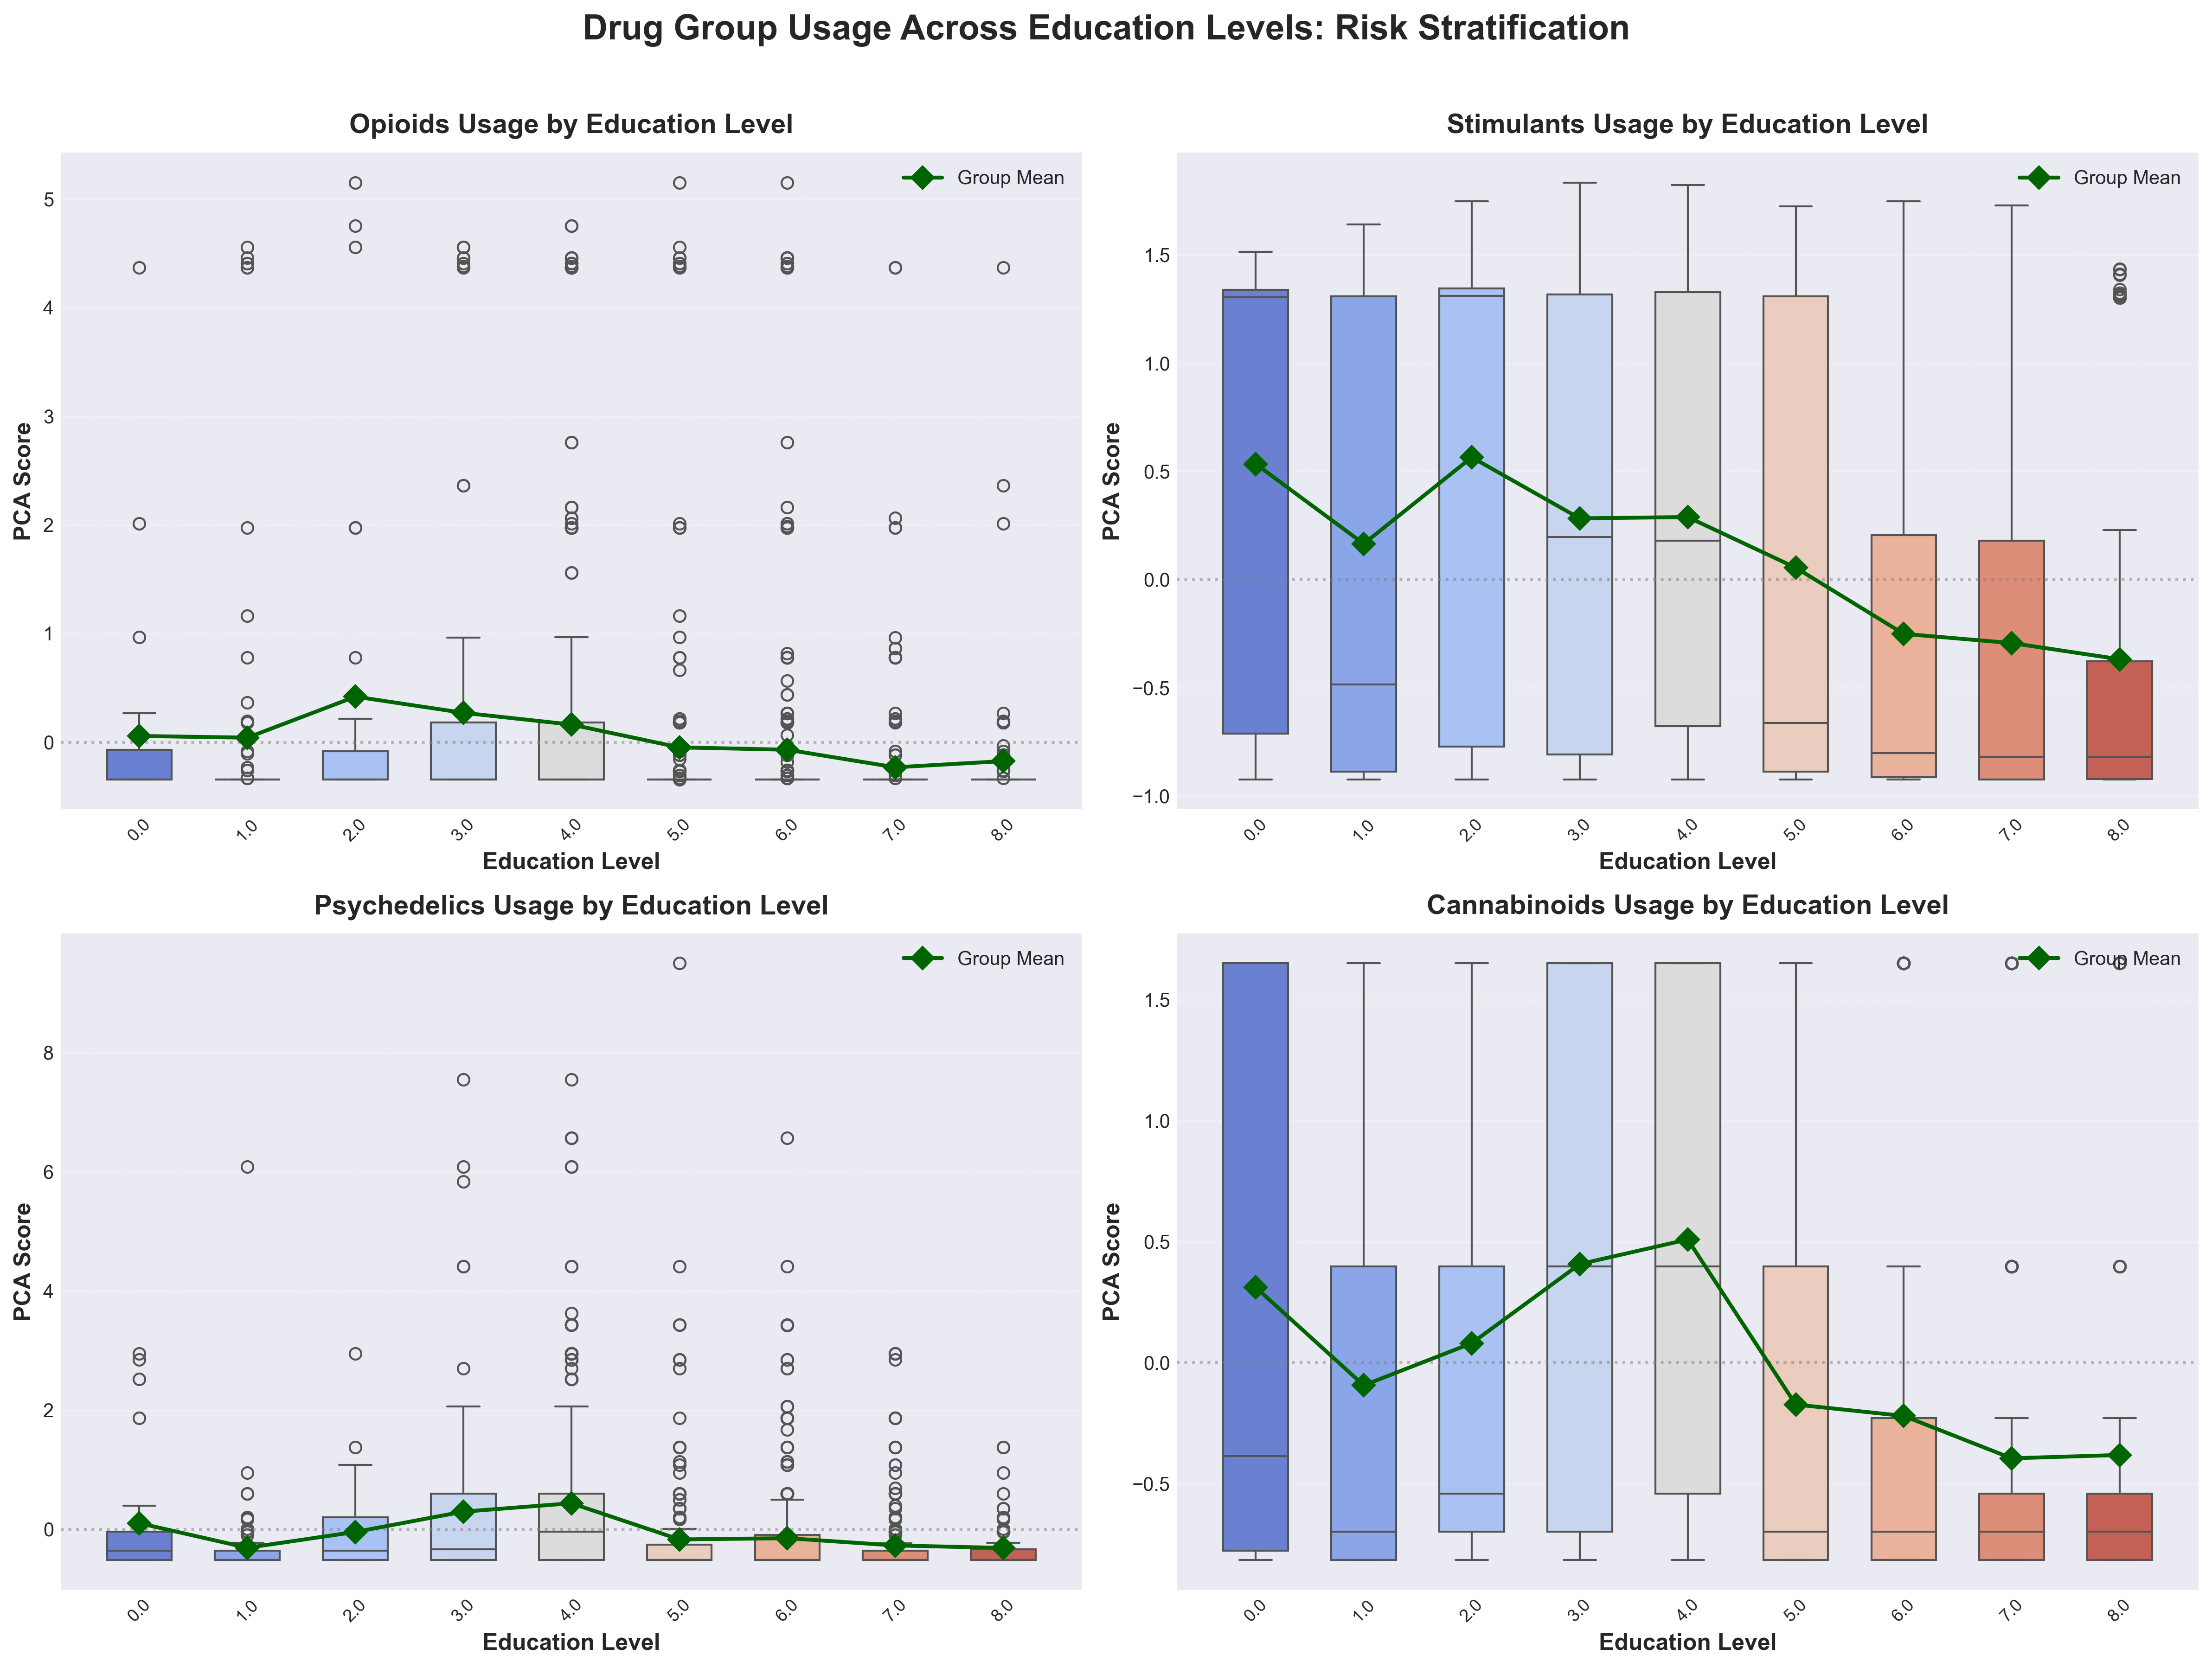

✓ Saved: PCA_Visuals/education_risk_stratification.png

Generating Visualization 4: Poly-Drug Use Patterns...


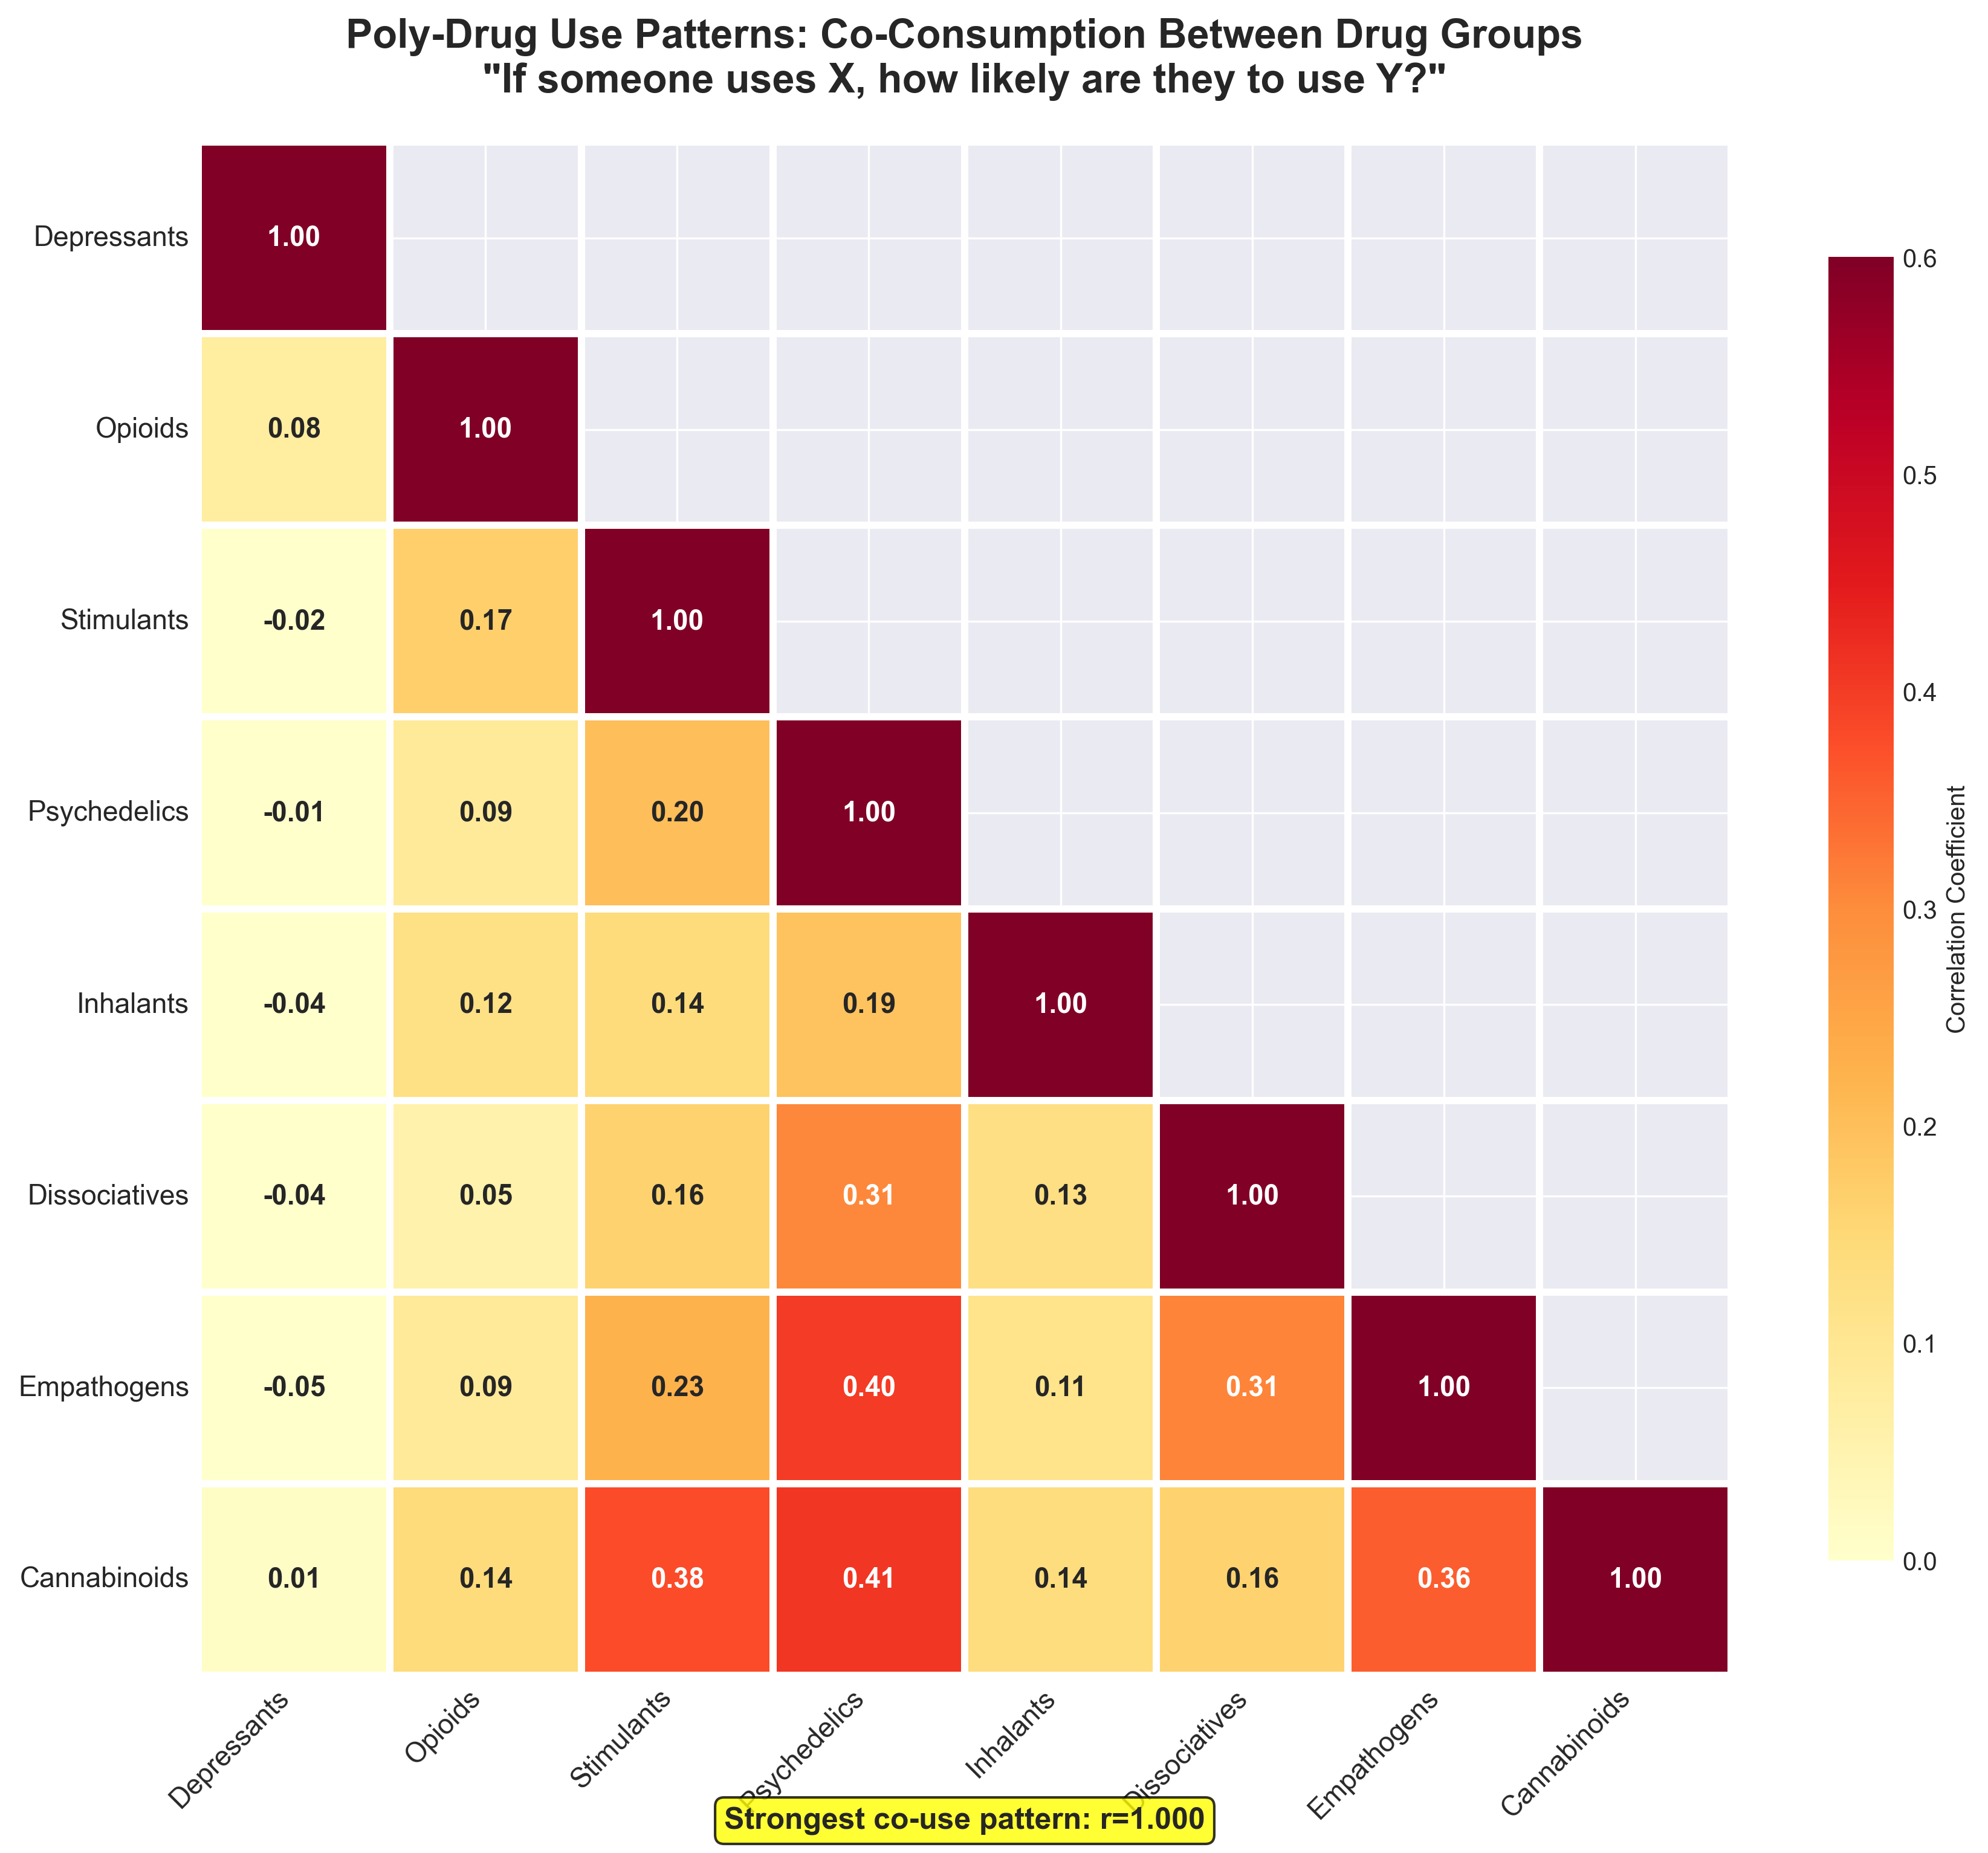

✓ Saved: PCA_Visuals/polydrug_use_patterns.png


In [23]:
# ============================================================================
# PCA DRUG GROUP VISUALIZATIONS - OPTIMIZED FOR PRESENTATION
# Purpose: Communicate dimensionality reduction effectiveness and model justification
# ============================================================================

import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import pearsonr

# Set publication-quality style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.dpi'] = 300  # High resolution for slides
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']

# Load processed data
df = pd.read_csv("processed_drug_consumption.csv")

# Define PCA drug group variables (in order matching your Drug Wheel)
group_pca_vars = [
    'depressants_pca',    # Alcohol, Benzodiazepines
    'opioids_pca',        # Heroin, Meth
    'stimulants_pca',     # Amphetamines, Cocaine, Crack, Nicotine
    'psychedelics_pca',   # LSD, Mushrooms
    'inhalants_pca',      # Amyl Nitrate, VSA
    'dissociatives',      # Ketamine
    'empathogens',        # Ecstasy
    'cannabinoids'        # Cannabis
]

# Readable labels for plots
group_labels = {
    'depressants_pca': 'Depressants',
    'opioids_pca': 'Opioids',
    'stimulants_pca': 'Stimulants',
    'psychedelics_pca': 'Psychedelics',
    'inhalants_pca': 'Inhalants',
    'dissociatives': 'Dissociatives',
    'empathogens': 'Empathogens',
    'cannabinoids': 'Cannabinoids'
}


# ============================================================================
# VISUALIZATION 1: Distribution Comparison - "The Groups Are Real"
# Purpose: Show that PCA created distinct, interpretable drug group patterns
# Slide Message: "8 coherent drug groups with unique usage patterns"
# ============================================================================

print("Generating Visualization 1: PCA Group Distributions...")

fig, axes = plt.subplots(2, 4, figsize=(18, 10))
axes = axes.flatten()

# Color palette for visual distinction
colors = sns.color_palette("Set2", n_colors=8)

for idx, col in enumerate(group_pca_vars):
    # Violin plot with enhanced styling
    parts = axes[idx].violinplot(
        df[col].dropna(), 
        positions=[0], 
        widths=0.7,
        showmeans=True,
        showmedians=True
    )
    
    # Color the violin
    for pc in parts['bodies']:
        pc.set_facecolor(colors[idx])
        pc.set_alpha(0.7)
        pc.set_edgecolor('black')
        pc.set_linewidth(1.5)
    
    # Enhance mean/median lines
    parts['cmeans'].set_color('darkred')
    parts['cmeans'].set_linewidth(2)
    parts['cmedians'].set_color('navy')
    parts['cmedians'].set_linewidth(2)
    
    # Add summary statistics as text
    mean_val = df[col].mean()
    median_val = df[col].median()
    std_val = df[col].std()
    
    axes[idx].set_title(
        f'{group_labels[col]}', 
        fontsize=14, 
        fontweight='bold',
        pad=10
    )
    axes[idx].set_ylabel('PCA Score (Weighted Usage)', fontsize=11)
    axes[idx].set_xticks([])
    axes[idx].grid(axis='y', alpha=0.3, linestyle='--')
    
    # Add text annotation with key statistics
    axes[idx].text(
        0.98, 0.98, 
        f'μ={mean_val:.2f}\nσ={std_val:.2f}',
        transform=axes[idx].transAxes,
        verticalalignment='top',
        horizontalalignment='right',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
        fontsize=9
    )
    
    axes[idx].axhline(y=0, color='gray', linestyle=':', linewidth=1, alpha=0.5)

plt.suptitle(
    'PCA Drug Group Distributions: Distinct Usage Patterns Across Categories',
    fontsize=18,
    fontweight='bold',
    y=0.98
)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('PCA_Visuals/pca_distributions.png', bbox_inches='tight', dpi=300)
plt.show()

print("✓ Saved: PCA_Visuals/pca_distributions.png")


# ============================================================================
# VISUALIZATION 2: Personality-Drug Group Correlation Heatmap
# Purpose: Link NEO-FFI-R personality traits to drug group risk
# Slide Message: "Personality traits predict drug group usage patterns"
# References your finding: "N↑ O↑ = risk↑; A↑ C↑ = risk↓"
# ============================================================================

print("\nGenerating Visualization 2: Personality-Drug Correlations...")

# Prepare personality traits
personality_traits = ['n_score', 'e_score', 'o_score', 'a_score', 'c_score']
trait_labels = {
    'n_score': 'Neuroticism (N)',
    'e_score': 'Extraversion (E)', 
    'o_score': 'Openness (O)',
    'a_score': 'Agreeableness (A)',
    'c_score': 'Conscientiousness (C)'
}

# Check which traits are available
available_traits = [t for t in personality_traits if t in df.columns]

if len(available_traits) >= 3:
    # Calculate correlations
    corr_data = df[group_pca_vars + available_traits].corr()
    drug_personality_corr = corr_data.loc[group_pca_vars, available_traits]
    
    # Rename for readability
    drug_personality_corr.index = [group_labels[g] for g in group_pca_vars]
    drug_personality_corr.columns = [trait_labels.get(t, t) for t in available_traits]
    
    # Create enhanced heatmap
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Use diverging colormap centered at 0
    sns.heatmap(
        drug_personality_corr,
        annot=True,
        fmt='.3f',
        cmap='RdBu_r',  # Red=positive, Blue=negative
        center=0,
        vmin=-0.3,
        vmax=0.3,
        square=True,
        linewidths=2,
        linecolor='white',
        cbar_kws={
            'label': 'Pearson Correlation Coefficient',
            'shrink': 0.8
        },
        annot_kws={'fontsize': 10, 'fontweight': 'bold'},
        ax=ax
    )
    
    plt.title(
        'NEO-FFI-R Personality Traits vs. Drug Group Usage\nValidating Risk Factor Predictions',
        fontsize=16,
        fontweight='bold',
        pad=20
    )
    plt.xlabel('Personality Traits (NEO-FFI-R)', fontsize=13, fontweight='bold')
    plt.ylabel('PCA Drug Groups', fontsize=13, fontweight='bold')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    
    # Add interpretation guide
    plt.text(
        0.5, -0.15,
        'Red = Higher trait → More usage  |  Blue = Higher trait → Less usage',
        transform=ax.transAxes,
        ha='center',
        fontsize=11,
        style='italic',
        bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8)
    )
    
    plt.tight_layout()
    plt.savefig('PCA_Visuals/personality_drug_correlation.png', bbox_inches='tight', dpi=300)
    plt.show()
    
    print("✓ Saved: PCA_Visuals/personality_drug_correlation.png")
    
    # Print key findings for slide notes
    print("\n📊 KEY FINDINGS FOR SLIDES:")
    for drug in group_pca_vars:
        drug_name = group_labels[drug]
        for trait in available_traits:
            trait_name = trait_labels[trait]
            corr_val = corr_data.loc[drug, trait]
            if abs(corr_val) > 0.15:  # Noteworthy correlations
                direction = "increases" if corr_val > 0 else "decreases"
                print(f"  • {trait_name} {direction} {drug_name} risk (r={corr_val:.3f})")
else:
    print("⚠ Personality traits not found in dataset")


# ============================================================================
# VISUALIZATION 3: Education-Based Risk Stratification
# Purpose: Show differential drug group usage across socioeconomic strata
# Slide Message: "Different demographics show different risk profiles"
# Supports: Targeted intervention strategies
# ============================================================================

print("\nGenerating Visualization 3: Education-Based Risk Profiles...")

if 'education' in df.columns:
    # Select subset of drug groups for clarity (avoid overcrowding)
    focus_groups = ['opioids_pca', 'stimulants_pca', 'psychedelics_pca', 'cannabinoids']
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()
    
    # Define education order (from your EDA)
    edu_order = sorted(df['education'].unique())
    
    # Color palette
    palette = sns.color_palette("coolwarm", n_colors=len(edu_order))
    
    for idx, col in enumerate(focus_groups):
        sns.boxplot(
            data=df,
            x='education',
            y=col,
            order=edu_order,
            ax=axes[idx],
            palette=palette,
            width=0.6
        )
        
        # Add mean markers
        means = df.groupby('education')[col].mean()
        means_ordered = [means[edu] for edu in edu_order]
        axes[idx].plot(
            range(len(edu_order)), 
            means_ordered, 
            marker='D', 
            color='darkgreen', 
            linewidth=2,
            markersize=8,
            label='Group Mean',
            zorder=10
        )
        
        axes[idx].set_title(
            f'{group_labels[col]} Usage by Education Level',
            fontsize=14,
            fontweight='bold',
            pad=10
        )
        axes[idx].set_xlabel('Education Level', fontsize=12, fontweight='bold')
        axes[idx].set_ylabel('PCA Score', fontsize=12, fontweight='bold')
        axes[idx].tick_params(axis='x', rotation=45, labelsize=9)
        axes[idx].grid(axis='y', alpha=0.3, linestyle='--')
        axes[idx].legend(loc='upper right')
        axes[idx].axhline(y=0, color='gray', linestyle=':', alpha=0.5)
    
    plt.suptitle(
        'Drug Group Usage Across Education Levels: Risk Stratification',
        fontsize=18,
        fontweight='bold',
        y=0.995
    )
    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.savefig('PCA_Visuals/education_risk_stratification.png', bbox_inches='tight', dpi=300)
    plt.show()
    
    print("✓ Saved: PCA_Visuals/education_risk_stratification.png")
else:
    print("⚠ Education variable not found")


# ============================================================================
# VISUALIZATION 4: Poly-Drug Use Patterns (Correlation Matrix)
# Purpose: Show co-consumption patterns between drug groups
# Slide Message: "Understanding poly-drug use for intervention targeting"
# Supports: Your model's ability to predict multiple drug group risks
# ============================================================================

print("\nGenerating Visualization 4: Poly-Drug Use Patterns...")

# Calculate inter-drug correlations
drug_corr = df[group_pca_vars].corr()

# Rename for readability
drug_corr.index = [group_labels[g] for g in group_pca_vars]
drug_corr.columns = [group_labels[g] for g in group_pca_vars]

# Create correlation matrix
fig, ax = plt.subplots(figsize=(12, 10))

# Mask for upper triangle (avoid redundancy)
mask = np.triu(np.ones_like(drug_corr, dtype=bool), k=1)

sns.heatmap(
    drug_corr,
    mask=mask,
    annot=True,
    fmt='.2f',
    cmap='YlOrRd',  # Yellow to Red for positive correlations
    vmin=0,
    vmax=0.6,
    square=True,
    linewidths=2.5,
    linecolor='white',
    cbar_kws={
        'label': 'Correlation Coefficient',
        'shrink': 0.85
    },
    annot_kws={'fontsize': 11, 'fontweight': 'bold'},
    ax=ax
)

plt.title(
    'Poly-Drug Use Patterns: Co-Consumption Between Drug Groups\n"If someone uses X, how likely are they to use Y?"',
    fontsize=16,
    fontweight='bold',
    pad=20
)
plt.xticks(rotation=45, ha='right', fontsize=11)
plt.yticks(rotation=0, fontsize=11)

# Highlight strongest correlation
max_corr = drug_corr.where(~mask).max().max()
if len(np.where((drug_corr.values == max_corr) & (~mask))[0]) > 0:
    plt.text(
        0.5, -0.1,
        f'Strongest co-use pattern: r={max_corr:.3f}',
        transform=ax.transAxes,
        ha='center',
        fontsize=12,
        fontweight='bold',
        bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.8)
    )

plt.tight_layout()
plt.savefig('PCA_Visuals/polydrug_use_patterns.png', bbox_inches='tight', dpi=300)
plt.show()

print("✓ Saved: PCA_Visuals/polydrug_use_patterns.png")
